In [1]:
import pickle
import sys
sys.path.insert(1, '../src/siamese_triplet')

In [2]:
import matplotlib as plt
%matplotlib inline
import numpy as np 
import pandas as pd 
import torch
import torchtext
from torchtext import data
import spacy
import os


import pandas as pd
import numpy
from sklearn.metrics import roc_auc_score


spacy_en = spacy.load('en')


SEED = 1234


In [3]:
TEXT = data.Field(lower=True,include_lengths=False, tokenize = 'spacy')

LABEL = data.Field( dtype = torch.int)

dataFields = {'content': ('content', TEXT), 
              'author_label': ('author_label', LABEL)}

In [4]:
data_dir = '../data/processed/'
data_name = 'longest_poems.json'

In [5]:
dataset= data.TabularDataset(path=data_dir+data_name, 
                                            format='json',
                                            fields=dataFields, 
                                            skip_header=True)

In [6]:
import random
SEED = 3
train_data, valid_data = dataset.split(split_ratio=0.8,random_state = random.seed(SEED))



In [7]:
' '.join(train_data.examples[0].content)

'that causes the broken grass to be green , or the rock to break in grass or the sun to be constant to earth sun of all sunflowers and days on bright iron bridges what shines on old hospitals as on my yard \n returning from san francisco one night , orlovsky in my room whalen in his peaceful chair a telegram from gene , naomi dead \n outside i bent my head to the ground under the bushes near the garage knew she was better \n at last not left to look on earth alone 2 years of solitude no one , at age nearing 60 old woman of skulls once long tressed naomi of bible \n or ruth who wept in america rebecca aged in newark david remembering his harp , now lawyer at yale \n or srul avrum israel abraham myself to sing in the wilderness toward god o elohim ! so to the end 2 days after her death i got her letter \n strange prophecies anew ! she wrote   the key is in the window , the key is in the sunlight at the window i have the key get married allen don t take drugs the key is in the bars , in t

In [8]:
MAX_VOCAB_SIZE = 20_000

TEXT.build_vocab(dataset, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

In [9]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

#from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

import matplotlib.pyplot as plt
%matplotlib inline

### New way tokenizing and batching

In [10]:
import spacy
nlp = spacy.load('en')

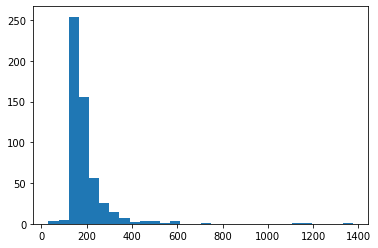

In [11]:
len_train = [len(i.content) for i in train_data.examples]
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(len_train,bins=30)
plt.show()

In [12]:
def pad_to_n(ls, n ):
    ls= ls[:n]
    if len(ls)<n: ls=(['<pad>']*(n-len(ls))) + ls
    return ls

In [13]:
def token2index(tokenized):
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]    
    tensor = torch.LongTensor(indexed)#.to(device)
    #tensor = tensor.unsqueeze(1) 
    #Note for the future: outmost sigmoid was included as part of the loss function
    return tensor

In [14]:
FIX_TEXT_LENGTH = 101
def to_Loader(data,labels):
    data = [pad_to_n(i, FIX_TEXT_LENGTH) for i in data]
    data = [token2index(i) for i in data]
    data = torch.stack(data)
        
    #labels= [(lambda y: 1 if y=='pos' else 0)(i) for i in labels]
    labels= torch.Tensor(labels)
    return data, labels

In [15]:
training_data_list = [i.content for i in train_data.examples]
training_labels_list = [i.author_label for i in train_data.examples]
training_data, training_labels= to_Loader(training_data_list, training_labels_list)

In [16]:
from datasets import BalancedBatchSampler
train_batch_sampler = BalancedBatchSampler(training_labels, n_classes=10, n_samples=10)
training_tensordataset = torch.utils.data.TensorDataset(training_data, training_labels)
training_Loader=torch.utils.data.DataLoader(training_tensordataset, batch_size=100,shuffle=True)#, sampler=train_batch_sampler)

In [17]:
validating_data_list = [i.content for i in valid_data.examples]
validating_labels_list = [i.author_label for i in valid_data.examples]
validating_data, validating_labels= to_Loader(validating_data_list, validating_labels_list)

In [18]:
valid_batch_sampler = BalancedBatchSampler(validating_labels, n_classes=10, n_samples=2)
validating_tensordataset = torch.utils.data.TensorDataset(validating_data, validating_labels)
validating_Loader=torch.utils.data.DataLoader(validating_tensordataset,batch_size=64)

## Plotting function

In [19]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
    
def extract_embeddings(dataloader, model, emb_dim):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), emb_dim))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for poems, target in dataloader:
            poems = poems.squeeze()
            poems_le= len(poems)
            if cuda:
                poems = poems.cuda()

            embeddings[k:k+poems_le] = model.get_embedding(poems).data.cpu().numpy()
            
            labels[k:k+poems_le] = target.numpy()
            k += poems_le
    return embeddings, labels

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

## Build the Model



In [20]:
sys.path.insert(1, '../src/')
from models import FastText, CNN, RNN

In [46]:
AUTHOR_DIM = 2

INPUT_DIM = len(TEXT.vocab)
WORD_EMBEDDING_DIM = 100 #Fixed by preloaded embedding 

PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model = FastText(INPUT_DIM, WORD_EMBEDDING_DIM, AUTHOR_DIM, PAD_IDX)


INPUT_DIM = len(TEXT.vocab)
WORD_EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3,4]

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 50 #256
 
N_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.75
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            AUTHOR_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, WORD_EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, AUTHOR_DIM, DROPOUT, PAD_IDX)


pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

model.embedding.weight.data[UNK_IDX] = torch.zeros(WORD_EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(WORD_EMBEDDING_DIM)

/Users/rene/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [47]:
# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric


import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from train import simplified_fit
import numpy as np
cuda = torch.cuda.is_available()


MARGIN = 0.03
embedding_net = EmbeddingNet()

#embedding_net = CNN_net # Uncomment to comeback to original version 
#MODEL = embedding_net
MODEL= model
if cuda:
    MODEL.cuda()
loss_fn = OnlineTripletLoss(MARGIN, RandomNegativeTripletSelector(MARGIN))
LR = 5e-3 
optimizer = optim.Adam(MODEL.parameters(), lr=LR, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 15
log_interval = 5

In [48]:
simplified_fit(training_Loader, training_Loader, MODEL, loss_fn, optimizer, 
    n_epochs, cuda, metrics=[AverageNonzeroTripletsMetric()],scheduler=scheduler)

/Users/rene/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/540 (0%)]	Loss: 0.484352	Average nonzero triplets: 712.0
Train: [303/540 (50%)]	Loss: 0.548224	Average nonzero triplets: 629.5
Epoch: 1/15. Train set: Average loss: 0.5307	Average nonzero triplets: 547.8333333333334
Epoch: 1/15. Validation set: Avg loss: 0.1398	Average nonzero triplets: 515.1666666666666
Train: [0/540 (0%)]	Loss: 0.578308	Average nonzero triplets: 577.0
Train: [303/540 (50%)]	Loss: 0.462707	Average nonzero triplets: 630.5
Epoch: 2/15. Train set: Average loss: 0.4401	Average nonzero triplets: 532.3333333333334
Epoch: 2/15. Validation set: Avg loss: 0.1136	Average nonzero triplets: 460.6666666666667
Train: [0/540 (0%)]	Loss: 0.365985	Average nonzero triplets: 639.0
Train: [303/540 (50%)]	Loss: 0.274041	Average nonzero triplets: 599.75
Epoch: 3/15. Train set: Average loss: 0.2666	Average nonzero triplets: 506.8333333333333
Epoch: 3/15. Validation set: Avg loss: 0.0712	Average nonzero triplets: 418.1666666666667
Train: [0/540 (0%)]	Loss: 0.180961	Average nonzero 

In [49]:
#fit(training_Loader, validating_Loader, MODEL, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

# Plotting time

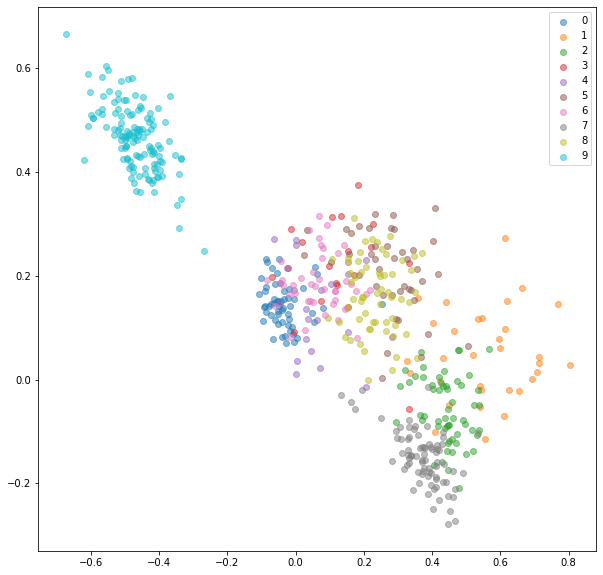

In [50]:
train_embeddings_otl, train_labels_otl = extract_embeddings(training_Loader, MODEL, AUTHOR_DIM)
plot_embeddings(train_embeddings_otl, train_labels_otl)

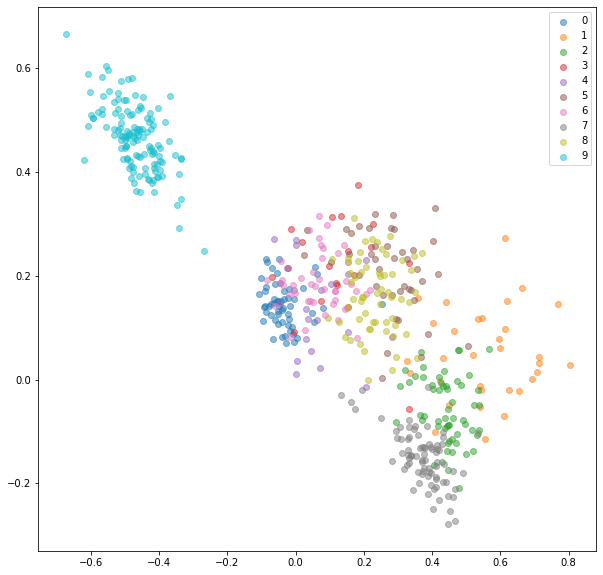

In [51]:

valid_embeddings_otl, valid_labels_otl = extract_embeddings(validating_Loader, MODEL, AUTHOR_DIM)
plot_embeddings(train_embeddings_otl, train_labels_otl)

In [52]:
from sklearn.neighbors import KNeighborsClassifier as KNC
KNN = KNC(n_neighbors=3)
KNN.fit(train_embeddings_otl, train_labels_otl)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [53]:
KNN.score(valid_embeddings_otl,valid_labels_otl)

0.5259259259259259

In [ ]:
nei= KNN.kneighbors(valid_embeddings_otl,3)

In [ ]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler

_data, _labels = (valid_embeddings_otl, valid_labels_otl)

standardized_data = StandardScaler().fit_transform(_data)
print(standardized_data.shape)
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(standardized_data)


tsne_data = np.vstack((tsne_data.T, _labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

In [ ]:
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()